In [ ]:
!pip install transformers evaluate

In [ ]:
import pandas as pd
from tqdm import tqdm

data = pd.read_csv('/content/all-data.csv', encoding='latin-1', header=None)
data.columns = ["labels", "text"]
data

,labels,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [ ]:
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

In [ ]:
accuracy = evaluate.load("accuracy")

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained(
    "ProsusAI/finbert", num_labels=3, # id2label=id2label, label2id=label2id
)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples, truncation=True)

texts = data["text"].to_list()
labels = data["labels"].to_list()
text_train, text_test, labels_train, labels_test = train_test_split(
    texts, labels, test_size=0.25, random_state=42,
)
tokenized_text_train = preprocess_function(text_train)
tokenized_text_test = preprocess_function(text_test)

print("train size:", len(labels_train))
print("test size:", len(labels_test))

train size: 3634
test size: 1212


In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

id2label = {0: "positive", 1: "neutral", 2: "negative"}
label2id = {"positive": 0, "neutral": 1, "negative": 2}

class BertDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, label2id):
        self.encodings = encodings
        self.labels = [label2id[value] for value in labels]
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BertDataset(tokenized_text_train, labels_train, label2id)
test_dataset = BertDataset(tokenized_text_test, labels_test, label2id)

In [ ]:
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

accuracy = evaluate.load("accuracy")

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained(
    "ProsusAI/finbert", num_labels=3, # id2label=id2label, label2id=label2id
)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def preprocess_function(examples):
    return tokenizer(examples, truncation=True)

texts = data["text"].to_list()
labels = data["labels"].to_list()
text_train, text_test, labels_train, labels_test = train_test_split(
    texts, labels, test_size=0.25, random_state=42,
)
tokenized_text_train = preprocess_function(text_train)
tokenized_text_test = preprocess_function(text_test)

print("train size:", len(labels_train))
print("test size:", len(labels_test))


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

id2label = {0: "positive", 1: "neutral", 2: "negative"}
label2id = {"positive": 0, "neutral": 1, "negative": 2}

class BertDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, label2id):
        self.encodings = encodings
        self.labels = [label2id[value] for value in labels]

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BertDataset(tokenized_text_train, labels_train, label2id)
test_dataset = BertDataset(tokenized_text_test, labels_test, label2id)

train size: 3634
test size: 1212


In [ ]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.train()
model = trainer.model

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-9-35302b81736c>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.297735,0.882838
2,No log,0.296034,0.896040


In [ ]:
train_preds = []
for text in tqdm(text_train):
    inputs = tokenizer(text, return_tensors="pt")
    logits = model(**inputs)
    predicted_class_id = logits.logits.argmax().item()
    train_preds.append(id2label[predicted_class_id])

test_preds = []
for text in tqdm(text_test):
    inputs = tokenizer(text, return_tensors="pt")
    logits = model(**inputs)
    predicted_class_id = logits.logits.argmax().item()
    test_preds.append(id2label[predicted_class_id])

100%|██████████| 1212/1212 [03:41<00:00,  5.47it/s]


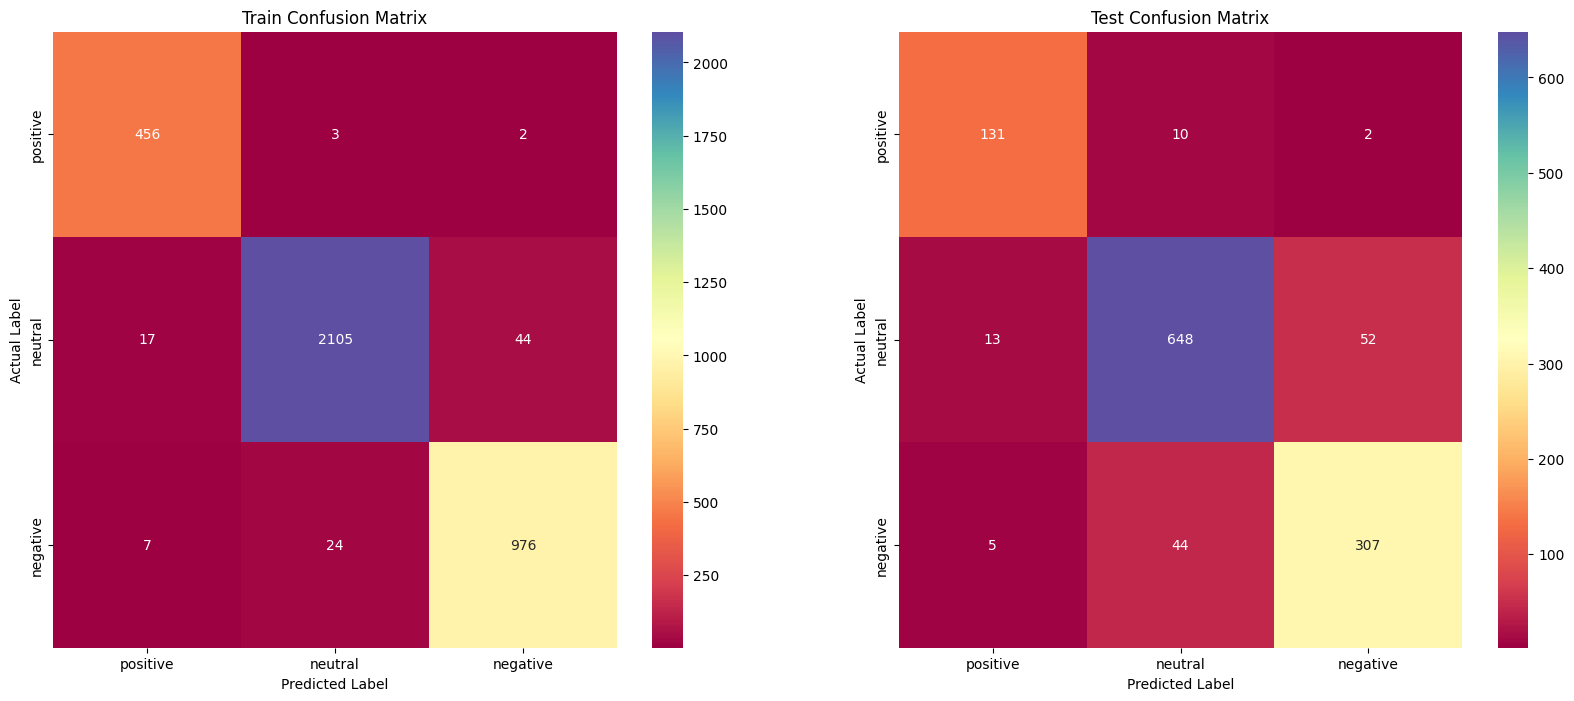

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

train_conf_mat = confusion_matrix(labels_train, train_preds)
test_conf_mat = confusion_matrix(labels_test, test_preds)

labels = list(label2id.keys())

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(train_conf_mat, annot=True, fmt='d',cmap='Spectral', xticklabels=labels, yticklabels=labels, ax=ax[0])
ax[0].set_title("Train Confusion Matrix")
ax[0].set_ylabel("Actual Label")
ax[0].set_xlabel("Predicted Label")

sns.heatmap(test_conf_mat, annot=True, fmt='d',cmap='Spectral', xticklabels=labels, yticklabels=labels, ax=ax[1])
ax[1].set_title("Test Confusion Matrix")
ax[1].set_ylabel("Actual Label")
ax[1].set_xlabel("Predicted Label")

plt.show()

In [ ]:
from sklearn.metrics import fbeta_score

train_f2_score = fbeta_score(labels_train, train_preds, beta=2, average='micro')
test_f2_score = fbeta_score(labels_test, test_preds, beta=2, average='micro')

print("Train F2 Score: ", train_f2_score)
print("Test F2 Score: ", test_f2_score)

Train F2 Score:  0.9733076499724821
Test F2 Score:  0.8960396039603961


In [ ]:
from sklearn.metrics import classification_report

train_report = classification_report(labels_train, train_preds, target_names=labels, digits=3)
test_report = classification_report(labels_test, test_preds, target_names=labels, digits=3)

print("Train Classification Report: ")
print(train_report)

print("\nTest Classification Report: ")
print(test_report)

Train Classification Report: 
              precision    recall  f1-score   support

    positive      0.950     0.989     0.969       461
     neutral      0.987     0.972     0.980      2166
    negative      0.955     0.969     0.962      1007

    accuracy                          0.973      3634
   macro avg      0.964     0.977     0.970      3634
weighted avg      0.974     0.973     0.973      3634


Test Classification Report: 
              precision    recall  f1-score   support

    positive      0.879     0.916     0.897       143
     neutral      0.923     0.909     0.916       713
    negative      0.850     0.862     0.856       356

    accuracy                          0.896      1212
   macro avg      0.884     0.896     0.890      1212
weighted avg      0.897     0.896     0.896      1212



In [ ]:
!pip install transformers evaluate

In [ ]:
import pandas as pd
from tqdm import tqdm

data = pd.read_csv('/content/all-data.csv', encoding='latin-1', header=None)
data.columns = ["labels", "text"]
data

,labels,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [ ]:
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

accuracy = evaluate.load("accuracy")

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=3, # id2label=id2label, label2id=label2id
)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def preprocess_function(examples):
    return tokenizer(examples, truncation=True)

texts = data["text"].to_list()
labels = data["labels"].to_list()
text_train, text_test, labels_train, labels_test = train_test_split(
    texts, labels, test_size=0.25, random_state=42,
)
tokenized_text_train = preprocess_function(text_train)
tokenized_text_test = preprocess_function(text_test)

print("train size:", len(labels_train))
print("test size:", len(labels_test))


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

id2label = {0: "positive", 1: "neutral", 2: "negative"}
label2id = {"positive": 0, "neutral": 1, "negative": 2}

class BertDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, label2id):
        self.encodings = encodings
        self.labels = [label2id[value] for value in labels]

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BertDataset(tokenized_text_train, labels_train, label2id)
test_dataset = BertDataset(tokenized_text_test, labels_test, label2id)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


train size: 3634
test size: 1212


In [ ]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.train()
model = trainer.model

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-26-35302b81736c>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.418784,0.826733
2,No log,0.379399,0.843234


In [ ]:
train_preds = []
for text in tqdm(text_train):
    inputs = tokenizer(text, return_tensors="pt")
    logits = model(**inputs)
    predicted_class_id = logits.logits.argmax().item()
    train_preds.append(id2label[predicted_class_id])

test_preds = []
for text in tqdm(text_test):
    inputs = tokenizer(text, return_tensors="pt")
    logits = model(**inputs)
    predicted_class_id = logits.logits.argmax().item()
    test_preds.append(id2label[predicted_class_id])

100%|██████████| 1212/1212 [01:51<00:00, 10.86it/s]


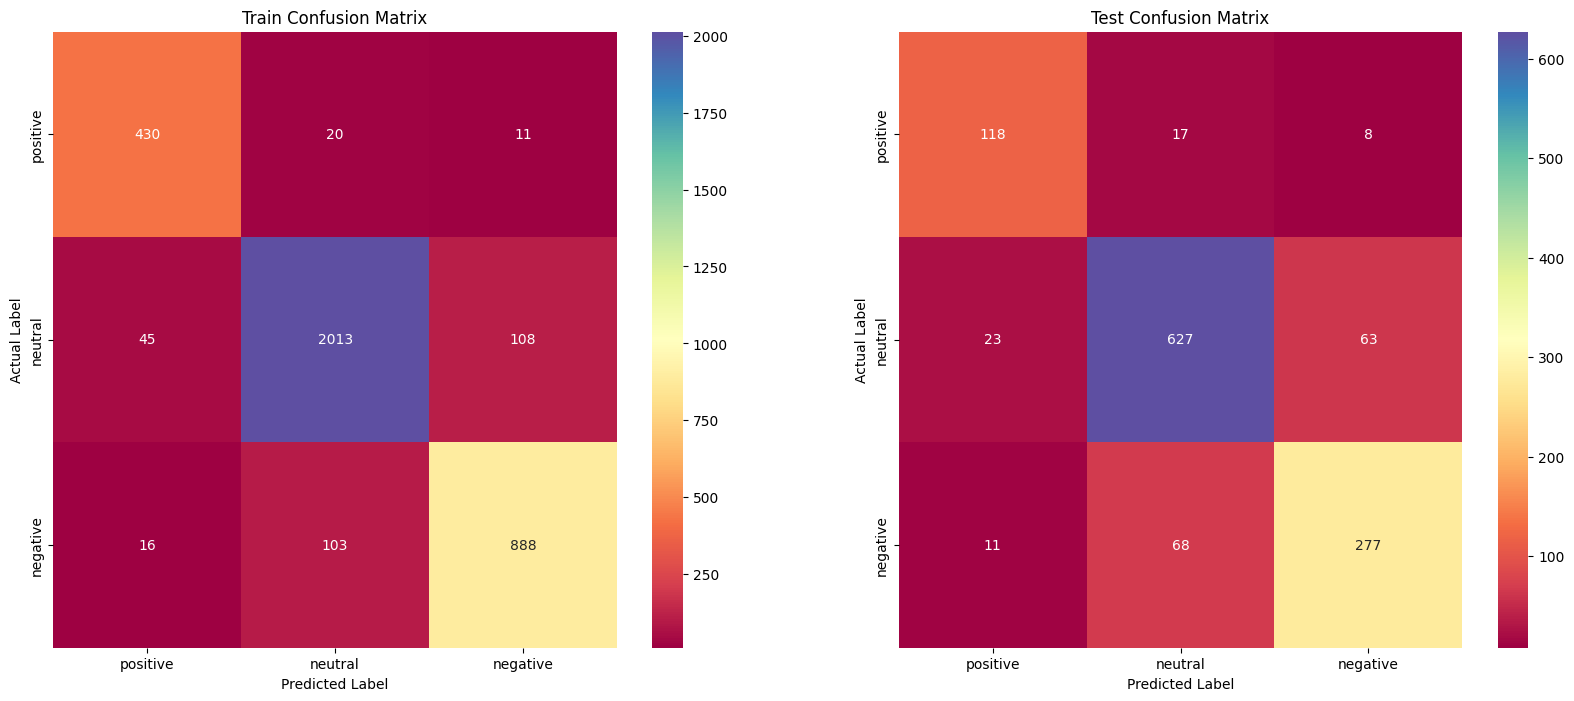

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

train_conf_mat = confusion_matrix(labels_train, train_preds)
test_conf_mat = confusion_matrix(labels_test, test_preds)

labels = list(label2id.keys())

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(train_conf_mat, annot=True, fmt='d',cmap='Spectral', xticklabels=labels, yticklabels=labels, ax=ax[0])
ax[0].set_title("Train Confusion Matrix")
ax[0].set_ylabel("Actual Label")
ax[0].set_xlabel("Predicted Label")

sns.heatmap(test_conf_mat, annot=True, fmt='d',cmap='Spectral', xticklabels=labels, yticklabels=labels, ax=ax[1])
ax[1].set_title("Test Confusion Matrix")
ax[1].set_ylabel("Actual Label")
ax[1].set_xlabel("Predicted Label")

plt.show()


In [ ]:
from sklearn.metrics import fbeta_score

train_f2_score = fbeta_score(labels_train, train_preds, beta=2, average='micro')
test_f2_score = fbeta_score(labels_test, test_preds, beta=2, average='micro')

print("Train F2 Score: ", train_f2_score)
print("Test F2 Score: ", test_f2_score)

Train F2 Score:  0.9166208035222895
Test F2 Score:  0.8432343234323433


In [ ]:
from sklearn.metrics import classification_report

train_report = classification_report(labels_train, train_preds, target_names=labels, digits=3)
test_report = classification_report(labels_test, test_preds, target_names=labels, digits=3)

print("Train Classification Report: ")
print(train_report)

print("\nTest Classification Report: ")
print(test_report)

Train Classification Report: 
              precision    recall  f1-score   support

    positive      0.876     0.933     0.903       461
     neutral      0.942     0.929     0.936      2166
    negative      0.882     0.882     0.882      1007

    accuracy                          0.917      3634
   macro avg      0.900     0.915     0.907      3634
weighted avg      0.917     0.917     0.917      3634


Test Classification Report: 
              precision    recall  f1-score   support

    positive      0.776     0.825     0.800       143
     neutral      0.881     0.879     0.880       713
    negative      0.796     0.778     0.787       356

    accuracy                          0.843      1212
   macro avg      0.818     0.828     0.822      1212
weighted avg      0.843     0.843     0.843      1212



In [ ]:
#bert
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

accuracy = evaluate.load("accuracy")

tokenizer = AutoTokenizer.from_pretrained("YituTech/conv-bert-base")
model = AutoModelForSequenceClassification.from_pretrained(
    "YituTech/conv-bert-base", num_labels=3, # id2label=id2label, label2id=label2id
)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def preprocess_function(examples):
    return tokenizer(examples, truncation=True)

texts = data["text"].to_list()
labels = data["labels"].to_list()
text_train, text_test, labels_train, labels_test = train_test_split(
    texts, labels, test_size=0.25, random_state=42,
)
tokenized_text_train = preprocess_function(text_train)
tokenized_text_test = preprocess_function(text_test)

print("train size:", len(labels_train))
print("test size:", len(labels_test))


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

id2label = {0: "positive", 1: "neutral", 2: "negative"}
label2id = {"positive": 0, "neutral": 1, "negative": 2}

class BertDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, label2id):
        self.encodings = encodings
        self.labels = [label2id[value] for value in labels]

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BertDataset(tokenized_text_train, labels_train, label2id)
test_dataset = BertDataset(tokenized_text_test, labels_test, label2id)

config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/267k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/423M [00:00<?, ?B/s]

Some weights of ConvBertForSequenceClassification were not initialized from the model checkpoint at YituTech/conv-bert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


train size: 3634
test size: 1212


In [ ]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.train()
model = trainer.model

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-34-4d0b29a7f4be>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.436592,0.833333
2,No log,0.373414,0.859736


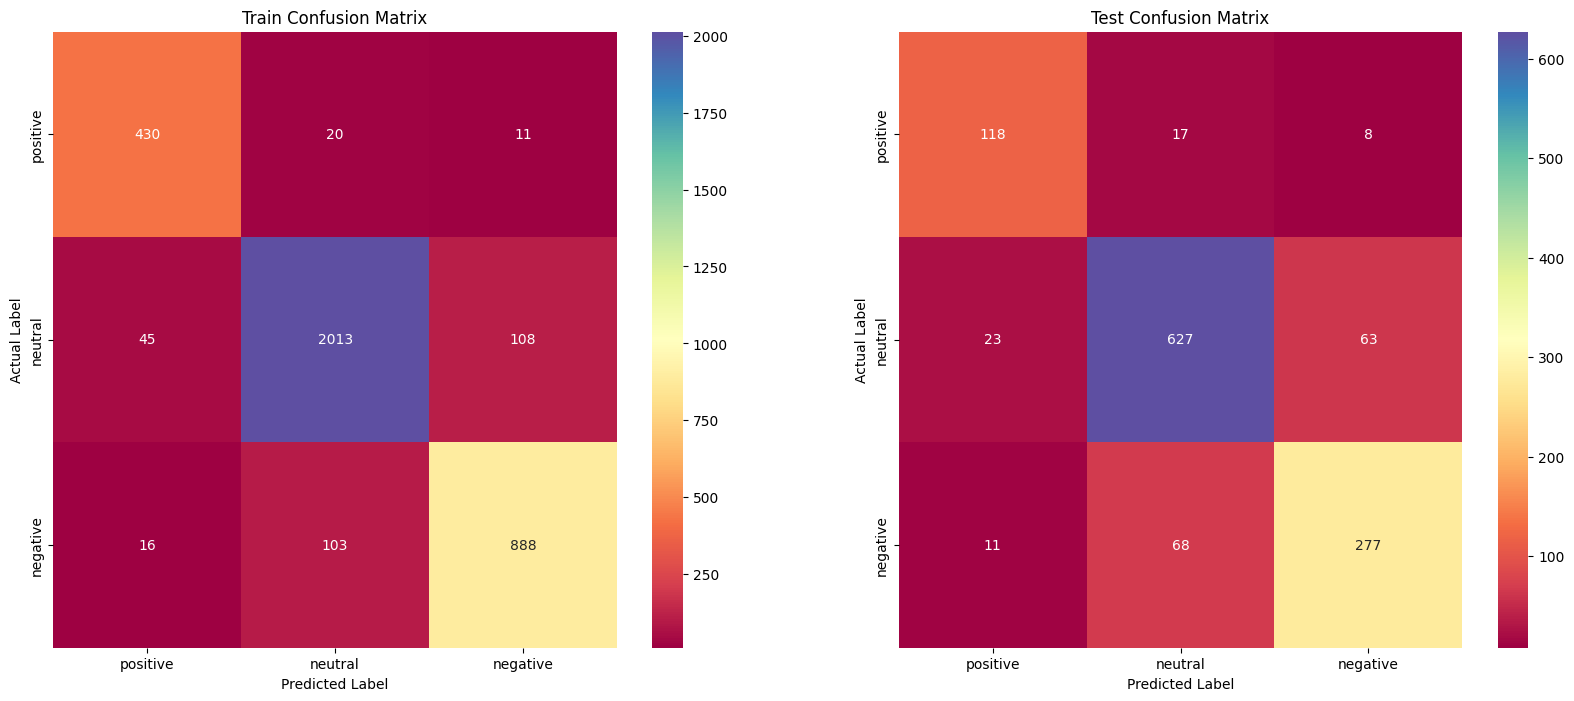

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

train_conf_mat = confusion_matrix(labels_train, train_preds)
test_conf_mat = confusion_matrix(labels_test, test_preds)

labels = list(label2id.keys())

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(train_conf_mat, annot=True, fmt='d', cmap='Spectral', xticklabels=labels, yticklabels=labels, ax=ax[0])
ax[0].set_title("Train Confusion Matrix")
ax[0].set_ylabel("Actual Label")
ax[0].set_xlabel("Predicted Label")

sns.heatmap(test_conf_mat, annot=True, fmt='d',cmap='Spectral', xticklabels=labels, yticklabels=labels, ax=ax[1])
ax[1].set_title("Test Confusion Matrix")
ax[1].set_ylabel("Actual Label")
ax[1].set_xlabel("Predicted Label")

plt.show()

In [ ]:
from sklearn.metrics import fbeta_score

train_f2_score = fbeta_score(labels_train, train_preds, beta=2, average='micro')
test_f2_score = fbeta_score(labels_test, test_preds, beta=2, average='micro')

print("Train F2 Score: ", train_f2_score)
print("Test F2 Score: ", test_f2_score)

Train F2 Score:  0.9166208035222895
Test F2 Score:  0.8432343234323433


In [ ]:
from sklearn.metrics import classification_report

train_report = classification_report(labels_train, train_preds, target_names=labels, digits=3)
test_report = classification_report(labels_test, test_preds, target_names=labels, digits=3)

print("Train Classification Report: ")
print(train_report)

print("\nTest Classification Report: ")
print(test_report)

Train Classification Report: 
              precision    recall  f1-score   support

    positive      0.876     0.933     0.903       461
     neutral      0.942     0.929     0.936      2166
    negative      0.882     0.882     0.882      1007

    accuracy                          0.917      3634
   macro avg      0.900     0.915     0.907      3634
weighted avg      0.917     0.917     0.917      3634


Test Classification Report: 
              precision    recall  f1-score   support

    positive      0.776     0.825     0.800       143
     neutral      0.881     0.879     0.880       713
    negative      0.796     0.778     0.787       356

    accuracy                          0.843      1212
   macro avg      0.818     0.828     0.822      1212
weighted avg      0.843     0.843     0.843      1212

